# COMS W2132 Intermediate Computing in Python
## Algorithm Analysis

**Date**: February 2 and February 4, 2026\
**Instructor**: Daniel Bauer \<bauer@cs.columbia.edu\> (original notes by Jan Janak)

**Reading**: DSAP Chapter 3

---

Much of this semester will be dedicated to studying data structures and related algorithms in Python. We are not interested in studying just about any data structures or algorithms. We are particularly interested in studying **good** and **appropriate** data structures and algorithms. But how do we tell if a data structure or an algorithm is good? And what does it mean for it to be good? This topic will be the subject of this section.

_We will only be covering the necessary algorithm analysis minimum here. This section aims to help you develop an intuition about data structures and algorithms._

## Outline
* Empirical approach
  * Counting operations, measuring input size
  * Worst / average / best case focus
* Essential growth rates
  * constant, logarithmic, linear, n-log-n, polynomial, exponential
  * Comparison and practical implications (with examples)
* Asymptotic analysis
  * More systematic characterization of running times
  * Big-O notation
  * Simple algorithm justification techniques (induction, loop invariants)

## Refresher

**Data structure**: A systematic way of organizing and accessing data.

**Algorithm**: A well-ordered sequence of operations that produce a result from some input and halt in a finite amount of time.

**Program**: A formal specification of an algorithm that can be understood by computers and other programmers ("a human-readable essay on computing"). A program implements an algorithm.

**Computing**: The activity of using or creating algorithmic processes to complete some task.

To tell if a data structure or an algorithm is good, we must have a precise way of analyzing it. Remember that an algorithm must finish in a finite amount of time (otherwise, it is not an algorithm). Thus, we can characterize algorithms by looking at their <u>running time</u>. Algorithms should run as fast as possible, thus the running time is a natural measure of goodness. The second criterion is its <u>memory usage</u>, i.e., the amount of memory the algorithm needs.

There are two general approaches to analyzing algorithms: empirical and analytical. The empirical approach relies on observations of the algorithm's running time or memory usage while processing various test inputs. The analytical approach analyzes the algorithm's specification in the form of a pseudo-code or program.

## Experimental Analysis (Empirical Approach)

What is the most straightforward way of studying an algorithm's running time? Run its program on a computer and measure the time it takes for the program to complete with various inputs!

Let's start with a simple example. Suppose we have a list of randomly generated numbers

In [49]:
import random
lst = [ random.randint(0, 99) for _ in range(1000000)]
print(lst[1:10])

[80, 59, 96, 92, 19, 80, 5, 67, 30]


In [51]:
len(lst)

1000000

And we write a function to find the minimum element in the list:

In [53]:
def find_min(lst):
    min = float('inf')
    for el in lst:
        if el < min:
            min = el
    return min

In [55]:
find_min(lst)

0

We run the function and measure the time it takes for it to complete:

In [87]:
from time import time
time()

1738614909.055825

In [120]:
from time import time

# Run this with and without stress and compare the elapsed time
start = time()
find_min(lst)
stop = time()
print(f'Elapsed time: {stop - start} s')

Elapsed time: 0.02963399887084961 s


If we generate more CPU load on the computer running this notebook the function will run longer. The running time of the find_min depends on the computer's hardware and software architecture and other currently running tasks! **Thus, this method is not reliable.** It also assumes that you have an implementation of the algorithm that you can run, which is not always the case.

Assume no other tasks are running on the computer. We want to know how the running time depends on various inputs, so we would need to run the program repeatably with inputs of different types and sizes:

In [131]:
n = 5000
times = []
for i in range(n):
    lst = [ random.randint(0, 99) for _ in range(i)]
    start = time()
    
    find_min(lst)

    stop = time()
    times.append(stop - start)

In [ ]:
times

The result then can be plotted:

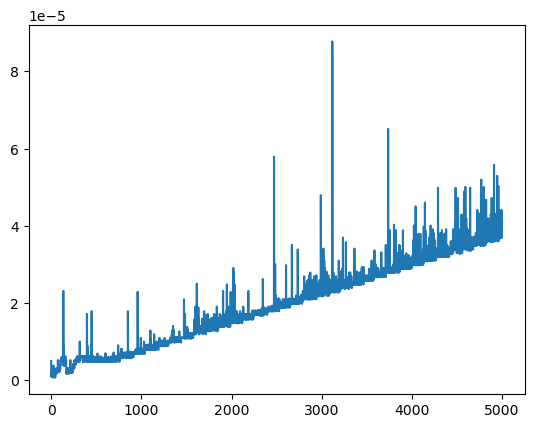

In [133]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(range(n), times)

We see some outliers in the graph. My computer interrupted the program to run other tasks in those cases. If we ignore those, we see that we could interpolate a line. We say that the algorithm has a linear running time.

Let's perform a similar measurement for the binary search algorithm. Recall that binary search requires a sorted input list, so we need to sort our list of numbers first.

In [139]:
from bisect import bisect_left

def binary_search(a, x):
    l = len(a)
    pos = bisect_left(a, x, 0, l)
    if pos != l and a[pos] == x:
        return pos
    else:
        return -1


n = 10000
times = []
for i in range(n):
    lst = sorted([ random.randint(0, 99) for _ in range(i)])
    start = time()
    
    binary_search(lst, 50)

    stop = time()
    times.append(stop - start)

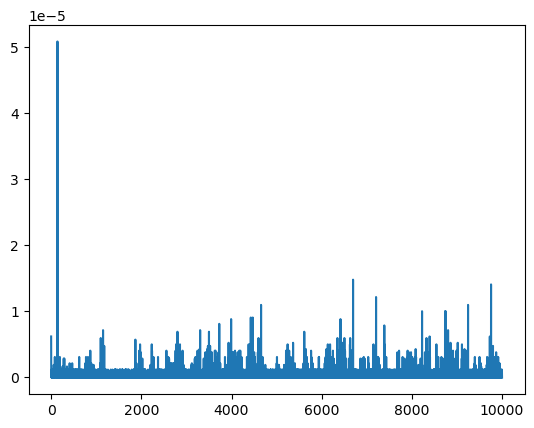

In [141]:
#plt.ylim(0, 0.6e-05)
plt.plot(range(n), times)

Question 1: How many iterations through the loop does binary search take?<br/>
Answer 1: 

Question 2: What is the worst that can happen?<br/>
Answer 2: 

Binary search has a logarithmic running time $T(N) = \log_2 N$ because, in every iteration, we split the list into two halves and search only one half.


This provides some intuition, but this method is generally unreliable. For more complicated cases that could not be eye-balled, we would need to perform statistical analysis to interpolate the data. But then we need good inputs and plenty of them to ensure the results are statistically significant. 

This method also does not allow comparing **algorithms**. 
* The comparison would be hardware dependent. 
* Different **programs** (in different languages) that implement the same **algorithm** may show different beheavior (at the margins).
* Sometimes a full implementation is not even available (we may want to decide on a good algorithm before implementing it).

This method is helpful in one case: the fine-tuning of production code. If you have some production code you are trying to optimize for performance, you could perform these measurements to learn how improvements and modifications affect it.

## Counting Primitive Operations

What if we wanted to analyze the running time of an algorithm:
  * Without the influence of the HW or SW architecture.
  * Based on a high-level description (without implementation)
  * Taking into account all possible inputs

If we cannot run experiments, we need to analyze some high-level description of the algorithm. The description will consist of primitive operations that somewhat correspond to low-level instructions of the computer.

**The key idea**: assume the running time of each primitive operation is to be constant. 

**Approach**: count how many primitive operations are executed. Use that as a measure of the running time of an algorithm.

What could those operations be? Let's take a look at some code and see what primitive operations it uses:

```python
# The following program uses binary search to find value x in a sorted list li.

left = 0
right = len(li) - 1
found = False

while right >= left and not found:
    mid = (left + right) // 2
    
    if li[mid] < x:
        left = mid + 1
    elif li[mid] > x:
        right = mid - 1
    else:
        print("Found", x, "at index", mid)
        found = True
        break
```
We have the following:
  * Assigning a value to a variable (e.g., left = 0)
  * Performing an arithmetic operation (e.g., mid + 1)
  * Calling a function (excluding the function's body)
  * Returning from a function
  * Comparing numbers (e.g., li\[mid\] < x)
  * Accessing a single element in a Python list (e.g., li\[mid\])

Thus, the program performs constant-time operations before entering the while loop and only constant-time operations inside the while loop. So, the overall running time of the program will be dominated by the number of loop iterations.

How many iterations are there? We see that the total number of iterations will be a function of the length of the list li. Recall how binary search works. We compare the searched item with the element in the middle of the list (called pivot). If not found, we repeat the process to the left or right **half** of the list, depending on the pivot value. This process is repeated until we find the item or run out of values. The length of the sub-list to be searched in every step halves. You can imagine that as traversing a binary tree from root to leaves. The height of the tree is $\log n$, where $n$ is the length of the list. Thus, the loop runs at most $\log n$ times.

## Running Time as Function of Input Size

Most of the time, we are interested in something other than how an algorithm performs for an input of a particular size. We are interested to learn about the **order of growth** of the algorithm's running time, i.e., how the running time grows when the input size grows.

Let's characterize the algorithm's running time as a function $f(n)$, where $n$ is the size of our input. The function characterizes the number of performed primitive operations as a function of input size $n$.

Many algorithms run faster for some inputs than others. Think about the binary search algorithm. What if the element we search for is in the middle? At the beginning? At the end?

We can identify a range of cases:
  * Best case: The set of inputs for which the algorithm runs the fastest
  * Average case: The average running time over all possible inputs of the same size
  * __Worst case: The set of inputs for which the algorithm runs the slowest__

The cases are summarized in the following diagram. Assuming input instances A through G are of the same size, we see that the algorithm runs faster for some and slower for others.

<img src="https://janakj.org/w3132/runtimes.png"/>

Which case best characterizes the algorithm? Intuitively, the average-case running time seems like the best characterization of the algorithm's running time because it averages its running time over all inputs of the same size. Unfortunately, average-case analysis requires us to define a probability distribution on the inputs, which can be challenging. The average-case running time is then the expected running time on the input distribution.

In this course, we will characterize algorithms in terms of their worst-case running time. Such analysis only requires that we identify the worst-case input, which is often not difficult and can be done intuitively. In many applications, knowing the algorithm's worst-case running time is what we want, as we are typically interested to establish an upper bound on the running time, i.e., guarantee that the algorithm is not going to be slower (but may be faster in some cases).

## Essential Growth Rate Functions

Theoretically, the function characterizing the algorithm's running time or memory requirements can be arbitrary. This makes algorithm analysis difficult in the general case. However, practically all algorithms we will study in this course can be characterized by one of the following six essential functions. Developing intuition about the growth rates of these six functions will allow us to compare most algorithms studied in this course.

|    |             |                                                     |
|----|-------------|-----------------------------------------------------|
| 1. | Constant    | $f(n) = c$                                          |
| 2. | Logarithm | $f(n) = \log_b{n}$ for $b > 1$                      |
| 3. | Linear      | $f(n) = n$                                          |
| 4. | N-Log-N     | $f(n) = n\log{n}$                                   |
| 5. | Polynomial  | $f(n) = a_0 + a_{1}{n} + a_{2}n^2 + ... + a_{d}n^d$ |
| 6. | Exponential |  $f(n) = b^n$                                       |

### The Constant Function

The constant function $f(n) = c$ for a fixed constant $c$ is the simplest function. _The running time of an algorithm with a constant growth rate does not depend on the size of the input._ We will be working with integer growth functions. The typical constant function will be $f(n) = 1$.

The constant function is useful in characterizing primitive operations on a computer, e.g., comparison, addition, or variable assignments (see the section Counting Primitive Operations above).


In [72]:
lst = [1, 2, 3, 4, 5]
print(len(lst))

5


### The Logarithm Function

The logarithm function is defined as $ x = \log_b n$ if and only if $ b^n = n$. By definition $ \log_b 1 = 0$.

The base $b$ in computer science is most commonly 2 because many algorithms repeatedly divide its inputs in half. It is so common that we will often write $\log n$ instead of $\log_2 n$.

Some rules to know:
  * Smallest integer greater $\geq \log_b n$, written as $\lceil \log_b n \rceil$): the number of times we can divide $n$ by $b$. For example, $\lceil \log_3 27 \rceil = ((27/3)/3)/3) = 1$
  * $\log_{b}(ac) = \log_{b} a + \log_{b} c $
  * $\log_{b}(a/c) = \log_{b} a - \log_{b} c$
  * $\log_{b}(a^c) = c \log_{b}(a)$
  * $\log_{b} a = \log_{d} a / \log_{d} b$   
  * $b^{\log_{d} a} = a^{\log_d b}$

### The Linear Function

The linear function is defined as $f(n) = n$. If the input is a collection, this function characterizes algorithms that perform constant-time operations for each element. Example: an algorithm that performs arithmetic operations over a list of integers.

In [75]:
def add_ten(lst):
    rv = []
    for item in lst:
        rv.append(item + 10)
    return rv

lst = [1, 2, 3]
print(add_ten(lst))

[11, 12, 13]


### The N-Log-N Function

The n-log-n function is defined as $f(n) = n \log n$, where the logarithm is of base 2.

Fastest possible general sorting algorithms require times proportional to $n \log n$. 

### The Polynomial Function

The polynomial function represents functions that are powers of the input size.

A polynomial function has the form $f(n) = a_0 + a_1 n + a_2 n^2 + a_3 n^3 + ... a_d n^d$, where $a$ are constants called the coefficients, $a_d$ is not zero. Integer $d$, which represents the highest power, is called the **degree** of the polynomial.

Running times with smaller degrees are better than running times with larger degrees.

Examples: f(n) = 1, f(n) = n, $f(n) = 3 + n^4$. Note: many of the function discussed so far belong to the polynomial class. You could argue that there are only four essential functions.

Quadratic function: $f(n) = n^2$

  * special case: quadratic and nested loops: $1 + 2 + 3 + ... + (n - 2) + (n - 1) + n = \frac{n(n + 1)}{2}$
  * special case: cubic functions

Know the summation notation: $ \sum_{i=a}^b f(i) = f(a) + f(a + 1) + f(a + 2) + ... + f(b)$

Summation notation for polynomials:
$f(n) = \sum_{i=0}^{d} a_in^i$

### The Exponential Function

The exponential function is of the form $f(n) = b^n$, where $b$ is a positive constant called the base and $n$ is the exponent.

How to understand this: this function: multiple the base n times. In CS, the most common base is 2, i.e., $f(n) = 2^n$.

Special: an integer of n bits can represent all non-negative integers less than $2^n$. Also: loops that double the number of operations in each iteration.

Reading:
  * proposition 3.4 in the textbook
  * Paragraphs on geometric sums in the textbook


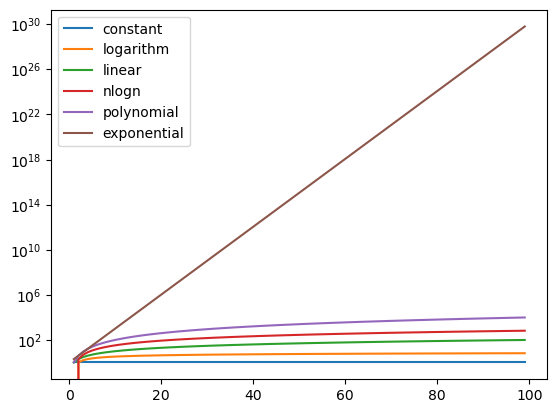

In [195]:
import math
from matplotlib import pyplot as plt
%matplotlib inline

n = 100

#plt.ylim(0, 100)
plt.yscale("log")

def constant():
    return 1
    
y = [ constant() for v in range(1, n) ]
plt.plot(range(1, n), y, label='constant')

def logarithm(v):
    return math.log2(v)

y = [ logarithm(v) for v in range(1, n) ]
plt.plot(range(1, n), y, label='logarithm')


def linear(v):
    return v

y = [ linear(v) for v in range(1, n) ]
plt.plot(range(1, n), y, label='linear')

def nlogn(v):
    return v * math.log2(v)

y = [ nlogn(v) for v in range(1, n) ]
plt.plot(range(1, n), y, label='nlogn')


def polynomial(v):
    return v * v

y = [ polynomial(v) for v in range(1, n) ]
plt.plot(range(1, n), y, label='polynomial')

def exponential(v):
    return math.pow(2, v)

y = [ exponential(v) for v in range(1, n) ]
plt.plot(range(1, n), y, label='exponential')

# def super_exponential(v):
#     return math.pow(v, v)

# y = [ super_exponential(v) for v in range(1, n) ]
# plt.plot(range(1, n), y, label='super_exponential')

plt.legend()

Summary: data operations ideally constant or logarithm

algorithms ideally linear or n-log-n

quadratic and cubit time is less practical

exponential is infeasible

## Asymptotic Analysis (Analytical Approach)

Approach:
  * Use a mathematical function notation
  * Disregard constant factors
  * Find the main factor that determines the growth rate in terms of input size $n$, i.e., disregard lower-order terms

Think back to the counting approach discussed earlier. Here, we **estimate** the number of primitive operations (to a constant factor) in a hardware/software-independent manner.

### Example: find_min revisited

Recall the find_min function discussed earlier:

In [89]:
def find_min(lst):
    "Return the minimum element from the given list"
    min = float('inf')    # constant time operation    c1
    for el in lst:        # iterate over each element in the input
        if el < min:      # constant-time operation
            min = el      # constant time operation c2  (including the test )
    return min

Running time is proportional to $n$ because the loop executes for each element and the rest are primitive constant-time operations.

f(N) = $c1 + n*c2 \propto n$ 

### The "Big-O" Notation

Suppose $f(n)$ and $g(n)$ are two functions mapping positive integers to real numbers. Further suppose that

$$
f(n) \leq c \cdot g(n)
$$
for $n \geq n_0$, a real constant $c \ge 0$, and an integer $n_0 \geq 1$.

We say that $f(n)$ "is big-O" of $g(n)$, or $f(n)$ is order of $g(n)$, written as $f(n)$ is $O(g(n))$.

**We can also say that $f(n)$ is "less than or equal to" $g(n)$ up to a constant factor when $n$ grows to infinity.**

<img src="https://janakj.org/w3132/big-o.png" width=500/>

If $f(n) = \log n$ and $g(n) = n$, we can say that $f(n)$ is $O(g(n))$, since $f(n) \leq c \cdot g(n)$ when $n \geq n_0$.

#### Some Examples

##### 1) 3n + 9 is O(n)

$f(n) = 3n + 9$\
$f(n)$ is $O(n)$

Justification: find $c > 0$ and $n_0$ so that $3n + 9 \leq cn$

##### 2) find_min is O(n)

Now that we have the big-O notation, we can say that the algorithm find_min for finding the minimum element in a list of length $n$ runs in $O(n$) time.

Justification: $c_1 + c_2 \cdot n$, which is at most $n$, disregarding the constant factors, thus find_min(n) is $O(n)$.

##### 3) $5n^2 + 3n\log n + 2n + 5$ is $O(n^2)$

Justification: The easiest way to do this is to show that each term is $O(N)$, and thus the sum also has to be $O(N)$. 

##### 4) $2^{n+2}$ is $O(2^n)$

Justification: find c > 0 and n_0 so that $2^{n+2} \leq c \cdot 2^n$. Note $2^{n+2} = 2^n \cdot 2^2$

#### Considerations
  * Always choose big-Oh as close to the function as possible
  * Do not include constants and lower-order terms in the big-Oh notation
  * The six essential functions (plus $n^2$) are most commonly used with big-O

The general idea is that the big-Oh notation should be as simple as possible.

### Complementing Big-Oh: Big-Omega and Big-Theta

#### Big-Omega
Big-Omega allows saying that a function grows at a rate that is "greather than or equal" than some other function (opposite of Big-Oh).

$$
f(n) \geq c \cdot g(n)
$$
for $n \geq n_0$, a real constant $c \ge 0$, and an integer $n_0 \geq 1$.

We say that $f(n)$ "is big-Omega" of $g(n)$ if $(g)$ is $O(f(n))$, written as $f(n)$ is $\Omega(g(n))$.

#### Big_Theta
Big-Theta allows saying that two functions $f(n)$ and $g(n)$ grow at the same rate up to a constant factor.

$$
c_1 \cdot g(n) \leq f(n) \leq c_2 \cdot g(n)
$$
for $n \geq n_0$, a real constant $c \ge 0$, and an integer $n_0 \geq 1$.

We say that $f(n)$ "is big-Theta" of $g(n)$ if $f(n)$ is $O(g(n))$ and $g(n)$ is $\Omega(f(n))$, written as $f(n)$ is $\Theta(g(n))$.

Example: $3n\log n + 4n + 5 \log n$ is $\Omega(n \log n)$ \
Justification for n >= 2: ...

$3n \log n + 4n + 5\log n \geq 3 n \log n$

### One More Example

#### The Prefix Average Algorithm

Given a sequence `S` of length n, create a new list `A` of the same length, such that each element of `A[i]` contains the average of the elements `S[0]...S[i]`.

* Length of list or index access: constant time
* Returning values: constant time



First version:
```python
def prefix_average1(S):
    n = len(S)                  # constant-time
    A = [0] * n                 # linear-time
    for j in range(n):          # linear time (n)
        total = 0               # constant time
        for i in range(j + 1):  # linear time (n)
            total += S[i]       # constant
        A[j] = total / (j + 1)  # constant, j+1 is the number of elements up to and including j
    return A                    # constant
```

n + n^2 = O(n^2)

Second version:

```python
def prefix_average2(S):
    n = len(S)             # constant time
    A = [0]* n            # linear
    total = 0              # constant
    for j in range(n):     # linear time (n)
        total += S[j]      # constant
        A[j] = total / (j + 1) # constant
    return A               # constant
```
n + n = O(n)

### Summary

  * For small n values, an asymptotically-better algorithm is not always better
  * But, asymptotically slow algorithms will be beaten in the long run, even if the constant factor is worse
  * Improvements in hardware do not matter in the long run if the algorithm is asymptotically slow
  * Big-O can be misleading if the hidden factor is very large, for example, compare $100^{100}n$ with $10 n \log n$.

What is considered fast or efficient?
  * Data structures: linear and logarithm
  * Algorithms, n-log-n and polynomial

### Justification Techniques

Some algorithms are harder to justify than the prefix average algorithm. This will be the case for some of the algorithm introduced later in this course. In addition to showing how fast it runs, we may also need to rigorously show that it is correct. We will use mathematical language to justify our claims.

#### Induction

So far, we have been saying that some statement $f(n)$ is true for $n \geq 1$. Thus, we are making a statement about an infinite set of numbers. Claims like these can be formally justified with **induction and loop invariants**.

The induction techniques works as follows:
  1. We show that $f(n)$ is true for $n = 1$. This is often trivial.
  2. We justify that an *inductive step* is true for $n > k$ for some arbitrary constant $k$.

In other words, we show that if $f(j)$ is true for all $j < n$ then $f(n)$ is true.

##### Example: Fibonacci function

$fib(1) = 1$, $fib(2) = 2$, $fib(n) = fib(n - 2) + fib(n - 1)$ for $n > 2$.

We claim that $fib(n) < 2^n$.

Base case: $fib(1) = 1 < 2^1$, and $fib(2) = 1 < 2^2$.

Inductive step for $n > 2$: 

   * $fib(n) = fib(n - 2) + fib(n - 1)$.

   * By the inductive hypothesis, we have that $fib(n) < 2^{n - 2} + 2^{n -1}$. And $2^{n-2} + 2^{n-1} < 2^{n-1} + 2^{n-1} = 2 \cdot 2^{n-1} = 2^n$.

#### Loop Invariants

This technique is useful for proving statements about loops. It works as follows:
  1. Define the loops in terms of statements $L_0$, $L_1$, ..., $L_k$.
  2. Prove an initial claim $L_0$ is true before the loop begins
  3. If $L_{j-1}$ is true before iteration $j$, then $L_j$ will be true after iteration $j$.
  4. $L_k$ implies $L$ is true.

In [70]:
def find(S, val):
    n = len(S)
    j = 0
    while j < n:
        if S[j] == val:
            return j
        j += 1
    return -1

Our claim ($L_j$): val is not equal to any of the first $j$ elements of $S$.

  * Trivially tru for $j = 0$
  * In iteration $j$, we return if they are equivalent. Otherwise we increment $j$ and $L_j$ is correct in next iteration.
  * If we terminate without returning, we have $j = n$, i.e., $L_n$ is true, there are no elements equal to val.